### BISMILLAH TUGAS AKHIR
#### SGTransformer with Edge Features

#### LIBRARY

In [1]:
pip install dgl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import dgl
import PIL
import json
import math
import torch
import random
import numpy as np

import torch.nn as nn
import networkx as nx
from tqdm import tqdm
import dgl.function as fn
from einops import rearrange
from scipy import sparse as sp
import matplotlib.pyplot as plt
import torch.nn.functional as F
from omegaconf import OmegaConf
import torchvision.transforms as T
from torch.utils.data import Dataset

from skimage.transform import resize as imresize
from torchvision.ops import complete_box_iou_loss
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import to_tensor

#### a) DATASET PREPARATION

In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

INV_IMAGENET_MEAN = [-m for m in IMAGENET_MEAN]
INV_IMAGENET_STD = [1.0 / s for s in IMAGENET_STD]

def imagenet_preprocess():
    return T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)

class Resize(object):
    def __init__(self, size, interp=PIL.Image.BILINEAR):
        if isinstance(size, tuple):
            H, W = size
            self.size = (W, H)
        else:
            self.size = (size, size)
        self.interp = interp

    def __call__(self, img):
        return img.resize(self.size, self.interp)

In [4]:
def construct_dgl_graph(objects, triples, pos_enc_dim=16, triplet_type=None):
    s, p, o = triples.chunk(3, dim=1)
    p = p.squeeze(1)
    s, o = s.squeeze(), o.squeeze()
    s = s.view(-1)  # Mengubah s menjadi tensor satu dimensi
    o = o.view(-1)  # Mengubah o menjadi tensor satu dimensi
    g = dgl.graph((s, o)) #membuat graf. s dan o adalah dua array yang menyatakan sumber (source) dan tujuan (destination) dari setiap edge dalam grafik.
    pad_size = len(objects) - g.num_nodes()
    g.add_nodes(pad_size)
    g.ndata['feat'] = objects
    g.edata['feat'] = p
    if triplet_type is not None:
        g.edata['type'] = triplet_type
    laplacian_positional_encoding(g, pos_enc_dim)

    return g

In [5]:
class DatasetLoader(Dataset):
    def _build_vocab(self):
        self.vocab = {
            'object_name_to_idx': {},
            'pred_name_to_idx': {},
        }

        # build object_name_to_idx
        self.vocab['object_name_to_idx']['__poster__'] = 0
        self.vocab['object_name_to_idx']['info'] = 1
        self.vocab['object_name_to_idx']['logo'] = 2
        self.vocab['object_name_to_idx']['primary_image'] = 3
        self.vocab['object_name_to_idx']['subtitle'] = 4
        self.vocab['object_name_to_idx']['title'] = 5

        # build object_idx_to_name
        name_to_idx = self.vocab['object_name_to_idx']
        assert len(name_to_idx) == len(set(name_to_idx.values()))
        max_object_idx = max(name_to_idx.values())
        idx_to_name = ['NONE'] * (1 + max_object_idx)
        for name, idx in self.vocab['object_name_to_idx'].items():
            idx_to_name[idx] = name
        self.vocab['object_idx_to_name'] = idx_to_name
        # print( self.vocab['object_idx_to_name'])

        # build pred_idx_to_name
        self.vocab['pred_idx_to_name'] = [
            '__in_poster__',
            'left of',
            'right of',
            'above',
            'below',
            'inside',
            'surrounding',
        ]

        # build pred_name_to_idx
        self.vocab['pred_name_to_idx'] = {}
        for idx, name in enumerate(self.vocab['pred_idx_to_name']):
            self.vocab['pred_name_to_idx'][name] = idx

    def set_image_size(self, image_size):
        normalize_images=True
        print('called set_image_size', image_size)
        transform = [Resize(image_size), T.ToTensor()]
        if normalize_images:
            transform.append(imagenet_preprocess())
        self.transform = T.Compose(transform)
        self.image_size = image_size

    def __init__(self, image_size = (64,64)):
        direktori_magazine = './dataset'
        ekstensi_file = '.json'

        # Fungsi untuk memeriksa ekstensi file
        def is_json_file(file):
            return file.endswith(ekstensi_file)

        files = os.listdir(direktori_magazine)
        json_files = filter(is_json_file, files)
        file_layout_json = map(lambda file: os.path.join(direktori_magazine, file), json_files)
        self._build_vocab()
        self.set_image_size(image_size)
        
        def _process_layout_item(layout_path):
            with open(layout_path) as f:
                layout = json.load(f)
                
            layout_data = []

            for category in layout['components'].keys():
                # print(category)
                for item in layout['components'][category]:
                    temp_data = {
                        'category_id': self.vocab['object_name_to_idx'][category],
                        'bbox': item
                    }
                    layout_data.append(temp_data)

            objs, boxes = [], []
            WW = HH = 64.
            
            scale_factor_width = 64 / layout['width']
            scale_factor_height = 64 / layout['height']
            
            for object_data in layout_data:
                objs.append(object_data['category_id'])
                x0, y0, x1, y1 = object_data['bbox']
                
                x0 = x0 * scale_factor_width
                y0 = y0 * scale_factor_height
                x1 = x1 * scale_factor_width
                y1 = y1 * scale_factor_height

                boxes.append(torch.FloatTensor(
                     [x0 / WW, y0 / HH, x1 / WW, y1 / HH]))

            objs.append(self.vocab['object_name_to_idx']['__poster__'])
            boxes.append(torch.FloatTensor([0, 0, 1, 1]))

            objs = torch.LongTensor(objs)
            boxes = torch.stack(boxes, dim=0)
            
            obj_centers = []
            for i, obj_idx in enumerate(objs):
                x0, y0, x1, y1 = boxes[i]
                obj_centers.append([(x0 + x1) / 2, (y0 + y1) / 2])
                
            obj_centers = torch.FloatTensor(obj_centers)

            triples = []
            __image__ = self.vocab['object_name_to_idx']['__poster__']
            
            # print(objs)
            for item_idx, item in enumerate(objs):
                choices = [obj for obj in range(len(objs)) if (
                    obj != item_idx and obj != __image__)]
                if len(choices) == 0:
                    break

                other = random.choice(choices)
                if random.random() > 0.5:
                    s, o = item_idx, other
                else:
                    s, o = other, item_idx
                sx0, sy0, sx1, sy1 = boxes[s]
                ox0, oy0, ox1, oy1 = boxes[o]
                d = obj_centers[s] - obj_centers[o]
                theta = math.atan2(d[1], d[0])
                
                if sx0 < ox0 and sx1 > ox1 and sy0 < oy0 and sy1 > oy1:
                    p = 'surrounding'
                elif sx0 > ox0 and sx1 < ox1 and sy0 > oy0 and sy1 < oy1:
                    p = 'inside'
                elif theta >= 3 * math.pi / 4 or theta <= -3 * math.pi / 4:
                    p = 'left of'
                elif -3 * math.pi / 4 <= theta < -math.pi / 4:
                    p = 'above'
                elif -math.pi / 4 <= theta < math.pi / 4:
                    p = 'right of'
                elif math.pi / 4 <= theta < 3 * math.pi / 4:
                    p = 'below'
                p = self.vocab['pred_name_to_idx'][p]
                triples.append([s, p, o])
            triples = torch.LongTensor(triples)
            return objs, boxes, triples

        self.data = []

        for layout_path in file_layout_json:
            self.data.append(_process_layout_item(layout_path))

        self.num_samples = len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.num_samples

In [6]:
dataset = DatasetLoader()

called set_image_size (64, 64)


In [7]:
class SinePositionalEncoding(nn.Module):

    def __init__(self, emb_size, dropout=0.1, max_len=10):
        super(SinePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.emb_size = emb_size

        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x = x.to(self.pe.device)
        x = x * math.sqrt(self.emb_size)
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


def laplacian_positional_encoding(g, pos_enc_dim):
    """
        Graph positional encoding v/ Laplacian eigenvectors
        DGL implementation
    """
    n_nodes = g.number_of_nodes()
    pad_size = pos_enc_dim + 1 - n_nodes
    pad_size = max(0, pad_size)

    # Laplacian
    A = g.adjacency_matrix().to_dense().numpy().astype(float)
    N = sp.diags(dgl.backend.asnumpy(g.in_degrees()).clip(1)
                 ** -0.5, dtype=float).toarray()
    L = np.eye(n_nodes) - N @ A @ N
    # Eigenvectors with numpy
    EigVal, EigVec = np.linalg.eig(L)
    idx = EigVal.argsort()  # increasing order
    EigVal, EigVec = EigVal[idx], np.real(EigVec[:, idx])
    EigVec = np.pad(EigVec, (0, pad_size))[:n_nodes]
    g.ndata['lap_pos_enc'] = torch.from_numpy(
        EigVec[:, 1:pos_enc_dim+1]).float()

    return g

In [8]:
def dgl_coco_collate_all(dataset, pos_enc_dim=16):
    all_imgs, all_graphs, all_boxes = [], [], []
    max_objs = 0
    
    for sample in dataset:
        objs, boxes, triples = sample
        if objs.dim() == 0 or triples.dim() == 0:
            continue
        O, T = objs.size(0), triples.size(0)

        max_objs = max(max_objs, O)

        pad_size = max_objs - O
        # If pad size is 0, no element is concatenated (zero-dim tensor)
        boxes = torch.cat((boxes, torch.LongTensor([[0, 0, 1, 1]] * pad_size)))
        all_boxes.append(boxes)
        # If pad size is 0, no element is concatenated (zero-dim tensor)
        objs = torch.cat((objs, torch.LongTensor([0] * pad_size)))

        triples = triples.clone()
        graph = construct_dgl_graph(objs, triples, pos_enc_dim)
        all_graphs.append(graph)
        
    all_boxes = torch.cat(all_boxes)
    all_graphs = dgl.batch(all_graphs)
    out = (all_graphs, all_boxes)
    return out

In [9]:
train_dataset, val_dataset = train_test_split(dataset, test_size=0.16, random_state=42)

In [10]:
print(len(train_dataset))
print(len(val_dataset))

1081
207


In [11]:
train_dataset = dgl_coco_collate_all(train_dataset)
val_dataset = dgl_coco_collate_all(val_dataset)

#### b) MODELLING

In [12]:
def build_mlp(dim_list, activation='gelu', batch_norm='none',
              dropout=0.1, final_nonlinearity=True):
    layers = []
    for i in range(len(dim_list) - 1):
        dim_in, dim_out = dim_list[i], dim_list[i + 1]
            
        layers.append(nn.Linear(dim_in, dim_out))
        final_layer = (i == len(dim_list) - 2)
        
        if not final_layer or final_nonlinearity:
            if batch_norm == 'batch':
                layers.append(nn.BatchNorm1d(dim_out))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU())
            elif activation == 'gelu':
                layers.append(nn.GELU())
                
        if dropout > 0:
            layers.append(nn.Dropout(p=dropout))
            
    return nn.Sequential(*layers)


In [13]:
def src_dot_dst(src_field, dst_field, out_field):
    def func(edges):
        return {out_field: (edges.src[src_field] * edges.dst[dst_field])}
    return func

def scaling(field, scale_constant):
    def func(edges):
        return {field: ((edges.data[field]) / scale_constant)}
    return func

# Improving implicit attention scores with explicit edge features, if available
def imp_exp_attn(implicit_attn, explicit_edge):
    """
        implicit_attn: the output of K Q
        explicit_edge: the explicit edge features
    """
    def func(edges):
        return {implicit_attn: (edges.data[implicit_attn] * edges.data[explicit_edge])}
    return func

# To copy edge features to be passed to FFN_e
def out_edge_features(edge_feat):
    def func(edges):
        return {'e_out': edges.data[edge_feat]}
    return func


def exp(field):
    def func(edges):
        # clamp for softmax numerical stability
        return {field: torch.exp((edges.data[field].sum(-1, keepdim=True)).clamp(-5, 5))}
    return func




"""
    Single Attention Head
"""

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads, use_bias):
        super().__init__()
        
        self.out_dim = out_dim
        self.num_heads = num_heads
        
        if use_bias:
            self.Q = nn.Linear(in_dim, out_dim * num_heads, bias=True)
            self.K = nn.Linear(in_dim, out_dim * num_heads, bias=True)
            self.V = nn.Linear(in_dim, out_dim * num_heads, bias=True)
            self.proj_e = nn.Linear(in_dim, out_dim * num_heads, bias=True)
        else:
            self.Q = nn.Linear(in_dim, out_dim * num_heads, bias=False)
            self.K = nn.Linear(in_dim, out_dim * num_heads, bias=False)
            self.V = nn.Linear(in_dim, out_dim * num_heads, bias=False)
            self.proj_e = nn.Linear(in_dim, out_dim * num_heads, bias=False)
    
    def propagate_attention(self, g):
        # Compute attention score
        g.apply_edges(fn.u_dot_v('K_h', 'Q_h', 'score'))

        # Scaling
        g.apply_edges(lambda edges: {'score': edges.data['score'] / torch.sqrt(torch.tensor(self.out_dim))})

        # Use available edge features to modify the scores (proj_e)
        g.apply_edges(lambda edges: {'score': edges.data['score'] + edges.data['proj_e']})

        # Copy edge features as e_out to be passed to FFN_e
        g.apply_edges(lambda edges: {'e_out': edges.data['score']})

        # Softmax
        g.edata['score'] = dgl.ops.edge_softmax(g, g.edata['score'])

        # Message passing
        g.update_all(fn.u_mul_e('V_h', 'score', 'V_h'), fn.sum('V_h', 'wV'))

        # Copy 'score' to 'z' using ndata (node data)
        # g.ndata['z'] = g.edata['score']

        return g

    def forward(self, g, h, e):
        
        Q_h = self.Q(h)
        K_h = self.K(h)
        V_h = self.V(h)
        proj_e = self.proj_e(e)
        
        # Reshaping into [num_nodes, num_heads, feat_dim] to 
        # get projections for multi-head attention
        g.ndata['Q_h'] = Q_h.view(-1, self.num_heads, self.out_dim)
        g.ndata['K_h'] = K_h.view(-1, self.num_heads, self.out_dim)
        g.ndata['V_h'] = V_h.view(-1, self.num_heads, self.out_dim)
        g.edata['proj_e'] = proj_e.view(-1, self.num_heads, self.out_dim)
        
        self.propagate_attention(g)
        
        h_out = g.ndata['wV']
        e_out = g.edata['e_out']
        
        return h_out, e_out

In [14]:
class GraphTransformerLayer(nn.Module):
    """
        Param: 
    """

    def __init__(self, in_dim, out_dim, num_heads, dropout=0.0, layer_norm=False, batch_norm=True, residual=True, use_bias=False, mixed_precision=False):
        super().__init__()

        self.in_channels = in_dim
        self.out_channels = out_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.residual = residual
        self.layer_norm = layer_norm
        self.batch_norm = batch_norm

        self.mixed_precision = mixed_precision

        self.attention = MultiHeadAttentionLayer(
            in_dim, out_dim//num_heads, num_heads, use_bias)

        self.O_h = nn.Linear(out_dim, out_dim)
        self.O_e = nn.Linear(out_dim, out_dim)

        if self.layer_norm:
            self.layer_norm1_h = nn.LayerNorm(out_dim)
            self.layer_norm1_e = nn.LayerNorm(out_dim)

        if self.batch_norm:
            self.batch_norm1_h = nn.BatchNorm1d(out_dim)
            self.batch_norm1_e = nn.BatchNorm1d(out_dim)

        # FFN for h
        self.FFN_h_layer1 = nn.Linear(out_dim, out_dim*2)
        self.FFN_h_layer2 = nn.Linear(out_dim*2, out_dim)

        # FFN for e
        self.FFN_e_layer1 = nn.Linear(out_dim, out_dim*2)
        self.FFN_e_layer2 = nn.Linear(out_dim*2, out_dim)

        if self.layer_norm:
            self.layer_norm2_h = nn.LayerNorm(out_dim)
            self.layer_norm2_e = nn.LayerNorm(out_dim)

        if self.batch_norm:
            self.batch_norm2_h = nn.BatchNorm1d(out_dim)
            self.batch_norm2_e = nn.BatchNorm1d(out_dim)

    def forward(self, g, h, e, amp=False):
        h_in1 = h  # for first residual connection
        e_in1 = e  # for first residual connection

        # multi-head attention out
        h_attn_out, e_attn_out = self.attention(g, h, e)

        h = h_attn_out.view(-1, self.out_channels)
        e = e_attn_out.view(-1, self.out_channels)

        h = F.dropout(h, self.dropout, training=self.training)
        e = F.dropout(e, self.dropout, training=self.training)

        h = self.O_h(h)
        e = self.O_e(e)

        if self.residual:
            h = h_in1 + h  # residual connection
            e = e_in1 + e  # residual connection

        if self.layer_norm:
            h = self.layer_norm1_h(h)
            e = self.layer_norm1_e(e)

        if self.batch_norm:
            h = self.batch_norm1_h(h)
            e = self.batch_norm1_e(e)

        h_in2 = h  # for second residual connection
        e_in2 = e  # for second residual connection

        # FFN for h
        h = self.FFN_h_layer1(h)
        h = F.relu(h)
        h = F.dropout(h, self.dropout, training=self.training)
        h = self.FFN_h_layer2(h)

        # FFN for e
        e = self.FFN_e_layer1(e)
        e = F.relu(e)
        e = F.dropout(e, self.dropout, training=self.training)
        e = self.FFN_e_layer2(e)

        if self.residual:
            h = h_in2 + h  # residual connection
            e = e_in2 + e  # residual connection

        if self.layer_norm:
            h = self.layer_norm2_h(h)
            e = self.layer_norm2_e(e)

        if self.batch_norm:
            h = self.batch_norm2_h(h)
            e = self.batch_norm2_e(e)

        return h, e

    def __repr__(self):
        return '{}(in_channels={}, out_channels={}, heads={}, residual={})'.format(self.__class__.__name__,
                                                                                   self.in_channels,
                                                                                   self.out_channels, self.num_heads, self.residual)

In [15]:
class GraphTransformerNet(nn.Module):
    def __init__(self,
                 n_objs ,
                 n_rels ,
                 emb_size,
                 n_heads,
                 n_enc_layers,
                 pos_enc_dim,
                 dropout=0.1,
                 layer_norm=False,
                 batch_norm=True,
                 residual=True,
                 skip_edge_feat=False,
                 mixed_precision=False,
                 lap_pos_enc=True):
        super().__init__()
        out_dim = emb_size

        if lap_pos_enc:
            pos_enc_dim = pos_enc_dim
            self.embedding_lap_pos_enc = nn.Linear(pos_enc_dim, emb_size)

        self.lap_pos_enc = lap_pos_enc
        self.skip_edge_feat = skip_edge_feat
        self.embedding_h = nn.Embedding(n_objs, emb_size)

        if not skip_edge_feat:
            self.embedding_e = nn.Embedding(n_rels, emb_size)
        else:
            self.embedding_e = nn.Linear(1, emb_size)

        self.in_feat_dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList([
            GraphTransformerLayer(emb_size, emb_size, n_heads, dropout, layer_norm,
                                  batch_norm, residual, mixed_precision=mixed_precision)
            for _ in range(n_enc_layers-1)])
        self.layers.append(GraphTransformerLayer(emb_size, out_dim, n_heads, dropout,
                           layer_norm, batch_norm, residual, mixed_precision=mixed_precision))

        # print(self.layers)
        self.box_regressor = nn.Sequential(
            build_mlp([emb_size, emb_size //
                      2, emb_size // 4]),
            nn.Linear(emb_size // 4, 4),
            nn.Sigmoid()
        )
        
        self.box_regressor.apply(_init_weights)
    def forward(self, g):

        h = g.ndata['feat']
        e = g.edata['feat']
        h_lap_pos_enc = get_lap_pos_enc(g)
        # print(h)
        h = self.embedding_h(h)
        h = self.in_feat_dropout(h)

        if self.lap_pos_enc:
            h_lap_pos_enc = self.embedding_lap_pos_enc(h_lap_pos_enc.float())
            h = h + h_lap_pos_enc
        if self.skip_edge_feat:  # edge feature set to 1
            e = torch.ones(e.size(0), 1, device=h.device)
        e = self.embedding_e(e)

        # convnets
        # print(self.layers)
        for conv in self.layers:
            h, e = conv(g, h, e)

        # h = rearrange(h, '(b s) e -> b s e', b=g.batch_size)
        boxes = self.box_regressor(h)
        return boxes

    def loss(self, scores, targets):
        loss = nn.L1Loss()(scores, targets)
        return loss

In [16]:
def _init_weights(module):
    if hasattr(module, 'weight'):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight)

In [17]:
n_objs = 6  # Jumlah objek
n_rels = 7    # Jumlah relasi
emb_size = 128  # Ukuran embedding
n_heads = 4    # Jumlah kepala pada multi-head attention
n_enc_layers = 12  # Jumlah layer pada model
pos_enc_dim = 16  # Dimensi positional encoding

model = GraphTransformerNet(n_objs, n_rels, emb_size, n_heads, n_enc_layers, pos_enc_dim)
model

GraphTransformerNet(
  (embedding_lap_pos_enc): Linear(in_features=16, out_features=128, bias=True)
  (embedding_h): Embedding(6, 128)
  (embedding_e): Embedding(7, 128)
  (in_feat_dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-11): 12 x GraphTransformerLayer(in_channels=128, out_channels=128, heads=4, residual=True)
  )
  (box_regressor): Sequential(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=64, out_features=32, bias=True)
      (4): GELU(approximate='none')
      (5): Dropout(p=0.1, inplace=False)
    )
    (1): Linear(in_features=32, out_features=4, bias=True)
    (2): Sigmoid()
  )
)

#### c) TRAINING

In [18]:
def get_labels_from_graph(graph):
    labels = []
    subgraphs = dgl.unbatch(graph)
    for subgraph in subgraphs:
        labels.append(subgraph.ndata['feat'])
        
    labels = torch.stack(labels).to(graph.device)
    return labels

def get_lap_pos_enc(graph):
    # Implementation from graphtransformer
    lap_pos_enc = graph.ndata['lap_pos_enc']
    sign_flip = torch.rand(lap_pos_enc.size(1), device=graph.device)
    sign_flip[sign_flip >= 0.5] = 1.0
    sign_flip[sign_flip < 0.5] = -1.0
    lap_pos_enc = lap_pos_enc * sign_flip.unsqueeze(0)
    return lap_pos_enc

def run_model(graph):
    pred_boxes = model(graph)
    pred_boxes = pred_boxes.clamp(min=0, max=1)
    return pred_boxes

In [19]:
from tqdm import tqdm

def train_one_epoch(train_dataset, model, opt, scheduler):
    losses = ["box", "iou", "total"]
    epoch_losses = {k: 0 for k in losses}
    model.train()
    
    losses = training_step(train_dataset, model, opt, scheduler)
    epoch_losses = {k: v + losses[k] for k, v in epoch_losses.items()}
    epoch_losses = {k: v / len(train_dataset)
                    for k, v in epoch_losses.items()}
    return epoch_losses

def training_step(train_dataset, model, opt, scheduler):
    graph, boxes = train_dataset
    pred_boxes = run_model(graph)
    box_loss = F.mse_loss(pred_boxes, boxes)
    iou_loss = complete_box_iou_loss(pred_boxes, boxes, reduction='mean')
    
    loss = box_loss + iou_loss
    losses = {'box': box_loss.item(),"iou": iou_loss.item(), "total": loss.item()}
    
    opt.zero_grad()
    box_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    opt.step()
    scheduler.step()

    return losses

In [20]:
def evaluate(epoch, model, val_dataset):
    losses_epoch, layout, graph = eval_one_epoch(val_dataset)
    for key in losses_epoch.keys():
        print(f'eval/{key}', losses_epoch[key], epoch)
    return losses_epoch

def eval_one_epoch(val_dataset):
    losses = ["box", "iou", "total"]
    # print('val ', val_dataset)
    epoch_losses = {k: 0 for k in losses}
    model.eval()
    layout = {'gt': [], 'pred': []}
    graph, boxes = val_dataset
    with torch.no_grad():
        pred_boxes = run_model(graph)
        box_loss = F.mse_loss(pred_boxes, boxes)
        iou_loss = complete_box_iou_loss(
            pred_boxes, boxes, reduction='mean')

        loss = box_loss + iou_loss

        losses = {'box': box_loss.item(), "iou": iou_loss.item(), "total": loss.item()}

        epoch_losses = {k: v + losses[k]
                        for k, v in epoch_losses.items()}

    layout['gt_boxes'] = boxes
    layout['pred_boxes'] = pred_boxes

    epoch_losses = {k: v / len(val_dataset)
                    for k, v in epoch_losses.items()}
    return epoch_losses, layout, graph

In [23]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Inisialisasi optimizer (SGD) dengan learning rate awal 0.01
# opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=0.001)  

# Inisialisasi scheduler (Learning Rate Scheduler) yang mengurangi learning rate seiring berjalannya waktu
scheduler = lr_scheduler.StepLR(opt, step_size=10, gamma=0.4)

In [24]:
import matplotlib.pyplot as plt

def train_and_evaluate(epochs, train_loader, model, opt, val_dataset, patience):
    best_loss = float('inf')
    train_losses_history = {'box': [], 'iou': [], 'total': []}
    val_losses_history = {'box': [], 'iou': [],  'total': []}
    no_improvement_count = 0

    for epoch in range(epochs):
        print(f'Pelatihan [{epoch+1} / {epochs}]')
        train_losses = train_one_epoch(train_loader, model, opt, scheduler)

        for k, v in train_losses.items():
            print(f'pelatihan/{k}_loss', v, epoch)
        for key, value in train_losses.items():
            train_losses_history[key].append(value)
            
        print(f'Validasi [{epoch+1} / {epochs}]')
        val_losses = evaluate(epoch, model, val_dataset)  # Pastikan fungsi evaluasi ada
        for key, value in val_losses.items():
            val_losses_history[key].append(value)
            
        if val_losses['total'] < best_loss:
            best_loss = val_losses['total']
            torch.save(model.state_dict(), 'model_sgt_32.pth')
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break
        
        print()
        
    plot_losses(train_losses_history, val_losses_history)
    plot_losses_total(train_losses_history, val_losses_history)


def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses['box']) + 1)
    
    plt.figure(figsize=(8, 4)) 
    
    # Plot Box Loss
    plt.subplot(1, 2, 1)  # Menggunakan 1 baris dan 2 kolom subplot
    plt.plot(epochs, train_losses['box'], label='Train Box Loss')
    plt.plot(epochs, val_losses['box'], label='Validation Box Loss')
    plt.title('Box Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot IOU Loss
    plt.subplot(1, 2, 2)  # Menggunakan 1 baris dan 2 kolom subplot
    plt.plot(epochs, train_losses['iou'], label='Train IOU Loss')
    plt.plot(epochs, val_losses['iou'], label='Validation IOU Loss')
    plt.title('IOU Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()  # Mengatur layout agar tidak tumpang tindih
    plt.show()


def plot_losses_total(train_losses, val_losses):
    epochs = range(1, len(train_losses['total']) + 1)
    
    plt.figure(figsize=(8, 4)) 
    
    # Plot Total Loss
    plt.plot(epochs, train_losses['total'], label='Train Total Loss')
    plt.plot(epochs, val_losses['total'], label='Validation Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()  # Mengatur layout agar tidak tumpang tindih
    plt.show()

Pelatihan [1 / 300]
Linear(in_features=16, out_features=128, bias=True)
pelatihan/box_loss 0.13105911016464233 0
pelatihan/iou_loss 0.8474737405776978 0
pelatihan/total_loss 0.9785328507423401 0
Validasi [1 / 300]
Linear(in_features=16, out_features=128, bias=True)
eval/box 0.12040989100933075 0
eval/iou 3.29062557220459 0
eval/total 3.4110355377197266 0

Pelatihan [2 / 300]
Linear(in_features=16, out_features=128, bias=True)
pelatihan/box_loss 0.08014342933893204 1
pelatihan/iou_loss 0.6849979758262634 1
pelatihan/total_loss 0.7651414275169373 1
Validasi [2 / 300]
Linear(in_features=16, out_features=128, bias=True)
eval/box 0.09355636686086655 1
eval/iou 0.6774958372116089 1
eval/total 0.7710521817207336 1

Pelatihan [3 / 300]
Linear(in_features=16, out_features=128, bias=True)
pelatihan/box_loss 0.048228874802589417 2
pelatihan/iou_loss 0.7039889097213745 2
pelatihan/total_loss 0.7522177696228027 2
Validasi [3 / 300]
Linear(in_features=16, out_features=128, bias=True)
eval/box 0.0640

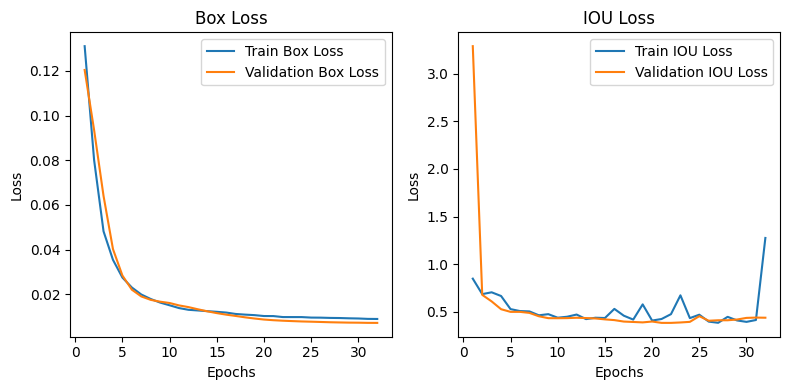

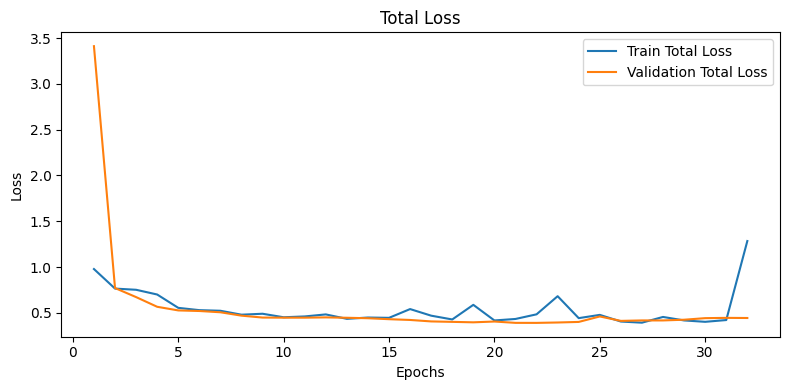

In [270]:
train_and_evaluate(300, train_dataset, model, opt, val_dataset, 10)

#### d) LOAD MODEL

In [21]:
def build_vocab():
    vocab = {
        'object_name_to_idx': {},
        'pred_name_to_idx': {},
    }

    # build object_name_to_idx
    vocab['object_name_to_idx']['__poster__'] = 0
    vocab['object_name_to_idx']['info'] = 1
    vocab['object_name_to_idx']['logo'] = 2
    vocab['object_name_to_idx']['primary_image'] = 3
    vocab['object_name_to_idx']['subtitle'] = 4
    vocab['object_name_to_idx']['title'] = 5

    # build object_idx_to_name
    name_to_idx = vocab['object_name_to_idx']
    assert len(name_to_idx) == len(set(name_to_idx.values()))
    max_object_idx = max(name_to_idx.values())
    idx_to_name = ['NONE'] * (1 + max_object_idx)
    for name, idx in vocab['object_name_to_idx'].items():
        idx_to_name[idx] = name
    vocab['object_idx_to_name'] = idx_to_name

    # build pred_idx_to_name
    vocab['pred_idx_to_name'] = [
        '__in_image__',
        'left of',
        'right of',
        'above',
        'below',
        'inside',
        'surrounding',
    ]

    # build pred_name_to_idx
    vocab['pred_name_to_idx'] = {}
    for idx, name in enumerate(vocab['pred_idx_to_name']):
        vocab['pred_name_to_idx'][name] = idx

    return vocab

def process_layout_item(layout, vocab):
    layout_data = []
    for category in layout['components'].keys():
        for item in layout['components'][category]:
            temp_data = {
                'category_id': vocab['object_name_to_idx'][category],
                'bbox': item
            }
            layout_data.append(temp_data)

    objs, boxes = [], []
    WW = HH = 64.

    scale_factor_width = 64 / layout['width']
    scale_factor_height = 64 / layout['height']

    for object_data in layout_data:
        objs.append(object_data['category_id'])
        x0, y0, x1, y1 = object_data['bbox']

        x0 = x0 * scale_factor_width
        y0 = y0 * scale_factor_height
        x1 = x1 * scale_factor_width
        y1 = y1 * scale_factor_height

        boxes.append(torch.FloatTensor(
             [x0 / WW, y0 / HH, x1 / WW, y1 / HH]))

    objs.append(vocab['object_name_to_idx']['__poster__'])
    boxes.append(torch.FloatTensor([0, 0, 1, 1]))

    objs = torch.LongTensor(objs)
    boxes = torch.stack(boxes, dim=0)

    obj_centers = []
    for i, obj_idx in enumerate(objs):
        x0, y0, x1, y1 = boxes[i]
        obj_centers.append([(x0 + x1) / 2, (y0 + y1) / 2])

    obj_centers = torch.FloatTensor(obj_centers)
    triples = []
    __image__ = vocab['object_name_to_idx']['__poster__']
    for item_idx, item in enumerate(objs):
        choices = [obj for obj in range(len(objs)) if (
            obj != item_idx and obj != __image__)]
        if len(choices) == 0:
            break

        other = random.choice(choices)
        if random.random() > 0.5:
            s, o = item_idx, other
        else:
            s, o = other, item_idx

        sx0, sy0, sx1, sy1 = boxes[s]
        ox0, oy0, ox1, oy1 = boxes[o]
        d = obj_centers[s] - obj_centers[o]
        theta = math.atan2(d[1], d[0])

        if sx0 < ox0 and sx1 > ox1 and sy0 < oy0 and sy1 > oy1:
            p = 'surrounding'
        elif sx0 > ox0 and sx1 < ox1 and sy0 > oy0 and sy1 < oy1:
            p = 'inside'
        elif theta >= 3 * math.pi / 4 or theta <= -3 * math.pi / 4:
            p = 'left of'
        elif -3 * math.pi / 4 <= theta < -math.pi / 4:
            p = 'above'
        elif -math.pi / 4 <= theta < math.pi / 4:
            p = 'right of'
        elif math.pi / 4 <= theta < 3 * math.pi / 4:
            p = 'below'
        p = vocab['pred_name_to_idx'][p]
        triples.append([s, p, o])

    triples = torch.LongTensor(triples)
    return objs, boxes, triples

def construct_dgl_graph(objects, triples, pos_enc_dim=32, triplet_type=None):
    s, p, o = triples.chunk(3, dim=1)
    p = p.squeeze(1)
    s, o = s.squeeze(), o.squeeze()
    s = s.view(-1)  # Mengubah s menjadi tensor satu dimensi
    o = o.view(-1)  # Mengubah o menjadi tensor satu dimensi
    g = dgl.graph((s, o))
    pad_size = len(objects) - g.num_nodes()
    g.add_nodes(pad_size)
    g.ndata['feat'] = objects
    g.edata['feat'] = p
    if triplet_type is not None:
        g.edata['type'] = triplet_type
    laplacian_positional_encoding(g, pos_enc_dim)
    return g

In [22]:
model = GraphTransformerNet(n_objs, n_rels, emb_size, n_heads, n_enc_layers, pos_enc_dim)
state_dict = torch.load('model_sgt_32.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [23]:
vocab = build_vocab()

#### e) DATA TEST

In [32]:
class TestDataset(Dataset):
    def _build_vocab(self):
        self.vocab = {
            'object_name_to_idx': {},
            'pred_name_to_idx': {},
        }

        # build object_name_to_idx
        self.vocab['object_name_to_idx']['__poster__'] = 0
        self.vocab['object_name_to_idx']['info'] = 1
        self.vocab['object_name_to_idx']['logo'] = 2
        self.vocab['object_name_to_idx']['primary_image'] = 3
        self.vocab['object_name_to_idx']['subtitle'] = 4
        self.vocab['object_name_to_idx']['title'] = 5

        # build object_idx_to_name
        name_to_idx = self.vocab['object_name_to_idx']
        assert len(name_to_idx) == len(set(name_to_idx.values()))
        max_object_idx = max(name_to_idx.values())
        idx_to_name = ['NONE'] * (1 + max_object_idx)
        for name, idx in self.vocab['object_name_to_idx'].items():
            idx_to_name[idx] = name
        self.vocab['object_idx_to_name'] = idx_to_name
        # print( self.vocab['object_idx_to_name'])

        # build pred_idx_to_name
        self.vocab['pred_idx_to_name'] = [
            '__in_poster__',
            'left of',
            'right of',
            'above',
            'below',
            'inside',
            'surrounding',
        ]

        # build pred_name_to_idx
        self.vocab['pred_name_to_idx'] = {}
        for idx, name in enumerate(self.vocab['pred_idx_to_name']):
            self.vocab['pred_name_to_idx'][name] = idx

    def set_image_size(self, image_size):
        normalize_images=True
        print('called set_image_size', image_size)
        transform = [Resize(image_size), T.ToTensor()]
        if normalize_images:
            transform.append(imagenet_preprocess())
        self.transform = T.Compose(transform)
        self.image_size = image_size

    def __init__(self, image_size = (64,64)):
        direktori_magazine = './data_test'
        ekstensi_file = '.json'

        # Fungsi untuk memeriksa ekstensi file
        def is_json_file(file):
            return file.endswith(ekstensi_file)

        files = os.listdir(direktori_magazine)
        json_files = filter(is_json_file, files)
        file_layout_json = map(lambda file: os.path.join(direktori_magazine, file), json_files)
        self._build_vocab()
        self.set_image_size(image_size)
        
        def _process_layout_item(layout_path):
            with open(layout_path) as f:
                layout = json.load(f)
                
            layout_data = []

            for category in layout['components'].keys():
                # print(category)
                for item in layout['components'][category]:
                    temp_data = {
                        'category_id': self.vocab['object_name_to_idx'][category],
                        'bbox': item
                    }
                    layout_data.append(temp_data)

            objs, boxes = [], []
            WW = HH = 64.
            
            scale_factor_width = 64 / layout['width']
            scale_factor_height = 64 / layout['height']
            
            for object_data in layout_data:
                objs.append(object_data['category_id'])
                x0, y0, x1, y1 = object_data['bbox']
                
                x0 = x0 * scale_factor_width
                y0 = y0 * scale_factor_height
                x1 = x1 * scale_factor_width
                y1 = y1 * scale_factor_height

                boxes.append(torch.FloatTensor(
                     [x0 / WW, y0 / HH, x1 / WW, y1 / HH]))

            objs.append(self.vocab['object_name_to_idx']['__poster__'])
            boxes.append(torch.FloatTensor([0, 0, 1, 1]))

            objs = torch.LongTensor(objs)
            boxes = torch.stack(boxes, dim=0)
            
            obj_centers = []
            for i, obj_idx in enumerate(objs):
                x0, y0, x1, y1 = boxes[i]
                obj_centers.append([(x0 + x1) / 2, (y0 + y1) / 2])
                
            obj_centers = torch.FloatTensor(obj_centers)

            triples = []
            __image__ = self.vocab['object_name_to_idx']['__poster__']
            
            # print(objs)
            for item_idx, item in enumerate(objs):
                choices = [obj for obj in range(len(objs)) if (
                    obj != item_idx and obj != __image__)]
                if len(choices) == 0:
                    break

                other = random.choice(choices)
                if random.random() > 0.5:
                    s, o = item_idx, other
                else:
                    s, o = other, item_idx
                sx0, sy0, sx1, sy1 = boxes[s]
                ox0, oy0, ox1, oy1 = boxes[o]
                d = obj_centers[s] - obj_centers[o]
                theta = math.atan2(d[1], d[0])
                
                if sx0 < ox0 and sx1 > ox1 and sy0 < oy0 and sy1 > oy1:
                    p = 'surrounding'
                elif sx0 > ox0 and sx1 < ox1 and sy0 > oy0 and sy1 < oy1:
                    p = 'inside'
                elif theta >= 3 * math.pi / 4 or theta <= -3 * math.pi / 4:
                    p = 'left of'
                elif -3 * math.pi / 4 <= theta < -math.pi / 4:
                    p = 'above'
                elif -math.pi / 4 <= theta < math.pi / 4:
                    p = 'right of'
                elif math.pi / 4 <= theta < 3 * math.pi / 4:
                    p = 'below'
                p = self.vocab['pred_name_to_idx'][p]
                # print("objs : ", objs)
                triples.append([s, p, o])
            triples = torch.LongTensor(triples)
            return objs, boxes, triples

        self.data = []

        for layout_path in file_layout_json:
            self.data.append(_process_layout_item(layout_path))

        self.num_samples = len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.num_samples

In [90]:
data_test = TestDataset()

called set_image_size (64, 64)


In [91]:
len(data_test)

140

In [143]:
test_dataset = dgl_coco_collate_all(data_test)
test_graph, test_boxes = test_dataset
test_pred_boxes = run_model(test_graph)

In [144]:
test_box_loss = F.mse_loss(test_pred_boxes, test_boxes)

In [145]:
test_iou_loss = complete_box_iou_loss(test_pred_boxes, test_boxes, reduction='mean')

In [146]:
print("box loss data test : ", test_box_loss.item())
print("iou loss data test : ", test_iou_loss.item())

box loss data test :  0.02081502601504326
iou loss data test :  0.9474754333496094


#### e) EVALUASI

##### FUNCTION

In [396]:
import torch
import multiprocessing as mp
from itertools import chain
from torch_geometric.data import Data, Batch
from torch_geometric.utils import to_dense_batch

In [397]:
def average(scores):
    return sum(scores) / len(scores)

def compute_alignment(bbox, mask):
    # Attribute-conditioned Layout GAN
    # 3.6.4 Alignment Loss
    bbox = bbox.permute(2, 0, 1)
    xl, yt, xr, yb = convert_xywh_to_ltrb(bbox)
    xc, yc = bbox[0], bbox[1]
    X = torch.stack([xl, xc, xr, yt, yc, yb], dim=1)

    X = X.unsqueeze(-1) - X.unsqueeze(-2)
    idx = torch.arange(X.size(2), device=X.device)
    X[:, :, idx, idx] = 1.
    X = X.abs().permute(0, 2, 1, 3)
    X[~mask] = 1.
    X = X.permute(0, 3, 2, 1)
    X[~mask] = 1.
    X = X.min(-1).values.min(-1).values
    X.masked_fill_(X.eq(1.), 0.)

    X = -torch.log(1 - X)

    return X.sum(-1) / mask.float().sum(-1)

def convert_xywh_to_ltrb(bbox):
    xc, yc, w, h = bbox
    x1 = xc - w / 2
    y1 = yc - h / 2
    x2 = xc + w / 2
    y2 = yc + h / 2
    return [x1, y1, x2, y2]

def compute_overlap(bbox, mask):
    # Attribute-conditioned Layout GAN
    # 3.6.3 Overlapping Loss

    bbox = bbox.masked_fill(~mask.unsqueeze(-1), 0)
    bbox = bbox.permute(2, 0, 1)

    l1, t1, r1, b1 = convert_xywh_to_ltrb(bbox.unsqueeze(-1))
    l2, t2, r2, b2 = convert_xywh_to_ltrb(bbox.unsqueeze(-2))
    a1 = (r1 - l1) * (b1 - t1)

    # intersection
    l_max = torch.maximum(l1, l2)
    r_min = torch.minimum(r1, r2)
    t_max = torch.maximum(t1, t2)
    b_min = torch.minimum(b1, b2)
    cond = (l_max < r_min) & (t_max < b_min)
    ai = torch.where(cond, (r_min - l_max) * (b_min - t_max),
                     torch.zeros_like(a1[0]))

    diag_mask = torch.eye(a1.size(1), dtype=torch.bool,
                          device=a1.device)
    ai = ai.masked_fill(diag_mask, 0)

    ar = torch.nan_to_num(ai / a1)

    return ar.sum(dim=(1, 2)) / mask.float().sum(-1)


In [398]:
def compute_iou(box_1, box_2):
    # box_1: [N, 4]  box_2: [N, 4]

    if isinstance(box_1, np.ndarray):
        lib = np
    elif isinstance(box_1, torch.Tensor):
        lib = torch
    else:
        raise NotImplementedError(type(box_1))

    l1, t1, r1, b1 = convert_xywh_to_ltrb(box_1.T)
    l2, t2, r2, b2 = convert_xywh_to_ltrb(box_2.T)
    a1, a2 = (r1 - l1) * (b1 - t1), (r2 - l2) * (b2 - t2)

    # intersection
    l_max = lib.maximum(l1, l2)
    r_min = lib.minimum(r1, r2)
    t_max = lib.maximum(t1, t2)
    b_min = lib.minimum(b1, b2)
    cond = (l_max < r_min) & (t_max < b_min)
    ai = lib.where(cond, (r_min - l_max) * (b_min - t_max),
                   lib.zeros_like(a1[0]))

    au = a1 + a2 - ai
    iou = ai / au

    return iou

def __compute_maximum_iou_for_layout(layout_1, layout_2):
    score = 0.
    (bi, li), (bj, lj) = layout_1, layout_2
    N = len(bi)
    for l in list(set(li.tolist())):
        _bi = bi[np.where(li == l)]
        _bj = bj[np.where(lj == l)]
        n = len(_bi)
        ii, jj = np.meshgrid(range(n), range(n))
        ii, jj = ii.flatten(), jj.flatten()
        iou = compute_iou(_bi[ii], _bj[jj]).reshape(n, n)
        ii, jj = linear_sum_assignment(iou, maximize=True)
        score += iou[ii, jj].sum().item()
    return score / N

def __compute_maximum_iou(layouts_1_and_2):
    layouts_1, layouts_2 = layouts_1_and_2
    N, M = len(layouts_1), len(layouts_2)
    ii, jj = np.meshgrid(range(N), range(M))
    ii, jj = ii.flatten(), jj.flatten()
    scores = np.asarray([
        __compute_maximum_iou_for_layout(layouts_1[i], layouts_2[j])
        for i, j in zip(ii, jj)
    ]).reshape(N, M)
    ii, jj = linear_sum_assignment(scores, maximize=True)
    return scores[ii, jj]

def compute_maximum_iou(layouts_1, layouts_2, n_jobs=None):
    c2bl_1 = __get_cond2layouts(layouts_1)
    keys_1 = set(c2bl_1.keys())
    # print('keys_1 : ', keys_1)
    c2bl_2 = __get_cond2layouts(layouts_2)
    keys_2 = set(c2bl_2.keys())
    # print('keys_2 : ', keys_2)
    keys = list(keys_1.intersection(keys_2))
    args = [(c2bl_1[key], c2bl_2[key]) for key in keys]
    with mp.Pool(n_jobs) as p:
        scores = p.map(__compute_maximum_iou, args)
    scores = np.asarray(list(chain.from_iterable(scores)))
    return scores.mean().item()

def __get_cond2layouts(layout_list):
    out = dict()
    for bs, ls in layout_list:
        cond_key = str(sorted(ls.tolist()))
        if cond_key not in out.keys():
            out[cond_key] = [(bs, ls)]
        else:
            out[cond_key].append((bs, ls))
    return out


In [399]:
def build_vocab():
    vocab = {
        'object_name_to_idx': {},
        'pred_name_to_idx': {},
    }

    # build object_name_to_idx
    vocab['object_name_to_idx']['__poster__'] = 0
    vocab['object_name_to_idx']['info'] = 1
    vocab['object_name_to_idx']['logo'] = 2
    vocab['object_name_to_idx']['primary_image'] = 3
    vocab['object_name_to_idx']['subtitle'] = 4
    vocab['object_name_to_idx']['title'] = 5

    # build object_idx_to_name
    name_to_idx = vocab['object_name_to_idx']
    assert len(name_to_idx) == len(set(name_to_idx.values()))
    max_object_idx = max(name_to_idx.values())
    idx_to_name = ['NONE'] * (1 + max_object_idx)
    for name, idx in vocab['object_name_to_idx'].items():
        idx_to_name[idx] = name
    vocab['object_idx_to_name'] = idx_to_name

    # build pred_idx_to_name
    vocab['pred_idx_to_name'] = [
        '__in_image__',
        'left of',
        'right of',
        'above',
        'below',
        'inside',
        'surrounding',
    ]

    # build pred_name_to_idx
    vocab['pred_name_to_idx'] = {}
    for idx, name in enumerate(vocab['pred_idx_to_name']):
        vocab['pred_name_to_idx'][name] = idx

    return vocab

def process_layout_item(layout, vocab):
    layout_data = []
    for category in layout['components'].keys():
        for item in layout['components'][category]:
            temp_data = {
                'category_id': vocab['object_name_to_idx'][category],
                'bbox': item
            }
            layout_data.append(temp_data)

    objs, boxes = [], []
    WW = HH = 64.

    scale_factor_width = 64 / layout['width']
    scale_factor_height = 64 / layout['height']

    for object_data in layout_data:
        objs.append(object_data['category_id'])
        x0, y0, x1, y1 = object_data['bbox']

        x0 = x0 * scale_factor_width
        y0 = y0 * scale_factor_height
        x1 = x1 * scale_factor_width
        y1 = y1 * scale_factor_height

        boxes.append(torch.FloatTensor(
             [x0 / WW, y0 / HH, x1 / WW, y1 / HH]))

    objs.append(vocab['object_name_to_idx']['__poster__'])
    boxes.append(torch.FloatTensor([0, 0, 1, 1]))

    objs = torch.LongTensor(objs)
    boxes = torch.stack(boxes, dim=0)

    obj_centers = []
    for i, obj_idx in enumerate(objs):
        x0, y0, x1, y1 = boxes[i]
        obj_centers.append([(x0 + x1) / 2, (y0 + y1) / 2])

    obj_centers = torch.FloatTensor(obj_centers)
    triples = []
    __image__ = vocab['object_name_to_idx']['__poster__']
    for item_idx, item in enumerate(objs):
        choices = [obj for obj in range(len(objs)) if (
            obj != item_idx and obj != __image__)]
        if len(choices) == 0:
            break

        other = random.choice(choices)
        if random.random() > 0.5:
            s, o = item_idx, other
        else:
            s, o = other, item_idx

        sx0, sy0, sx1, sy1 = boxes[s]
        ox0, oy0, ox1, oy1 = boxes[o]
        d = obj_centers[s] - obj_centers[o]
        theta = math.atan2(d[1], d[0])

        if sx0 < ox0 and sx1 > ox1 and sy0 < oy0 and sy1 > oy1:
            p = 'surrounding'
        elif sx0 > ox0 and sx1 < ox1 and sy0 > oy0 and sy1 < oy1:
            p = 'inside'
        elif theta >= 3 * math.pi / 4 or theta <= -3 * math.pi / 4:
            p = 'left of'
        elif -3 * math.pi / 4 <= theta < -math.pi / 4:
            p = 'above'
        elif -math.pi / 4 <= theta < math.pi / 4:
            p = 'right of'
        elif math.pi / 4 <= theta < 3 * math.pi / 4:
            p = 'below'
        p = vocab['pred_name_to_idx'][p]
        triples.append([s, p, o])

    triples = torch.LongTensor(triples)
    return objs, boxes, triples

def construct_dgl_graph(objects, triples, pos_enc_dim=32, triplet_type=None):
    s, p, o = triples.chunk(3, dim=1)
    p = p.squeeze(1)
    s, o = s.squeeze(), o.squeeze()
    s = s.view(-1)  # Mengubah s menjadi tensor satu dimensi
    o = o.view(-1)  # Mengubah o menjadi tensor satu dimensi
    g = dgl.graph((s, o))
    pad_size = len(objects) - g.num_nodes()
    g.add_nodes(pad_size)
    g.ndata['feat'] = objects
    g.edata['feat'] = p
    if triplet_type is not None:
        g.edata['type'] = triplet_type
    laplacian_positional_encoding(g, pos_enc_dim)
    return g

In [400]:
vocab = build_vocab()

##### REAL LAYOUT AND GENERATED LAYOUT

In [401]:
### REAL LAYOUT
test_layouts = []
for data in data_test:
    objs, boxes, triples = data
    bbox = boxes.detach().numpy()
    label = objs.detach().numpy()
    layout = (bbox, label)
    test_layouts.append(layout)

In [402]:
### GENERATED LAYOUT

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

folder_path = './data_test'  
generated_layouts = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            layout = json.load(file)
            data = process_layout_item(layout, vocab)
            graph = construct_dgl_graph(data[0], data[2], 16)
            pred_boxes = model(graph)
            pred_boxes = pred_boxes.detach().numpy()
            label = data[0]
            layout = (pred_boxes, label)
            generated_layouts.append(layout)

##### PERHITUNGAN METRIKS ALIGNMENT, OVERLAP DAN MAX_IOU
Referensi Metrik Evaluasi : https://github.com/ktrk115/const_layout/

In [411]:
import torch
import torch.nn as nn
from pytorch_fid.fid_score import calculate_frechet_distance
from scipy.optimize import linear_sum_assignment

class TransformerWithToken(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, num_layers):
        super().__init__()

        self.token = nn.Parameter(torch.randn(1, 1, d_model))
        token_mask = torch.zeros(1, 1, dtype=torch.bool)
        self.register_buffer('token_mask', token_mask)

        self.core = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=nhead,
                dim_feedforward=dim_feedforward,
            ), num_layers=num_layers)

    def forward(self, x, src_key_padding_mask):
        # x: [N, B, E]
        # padding_mask: [B, N]
        #   `False` for valid values
        #   `True` for padded values

        B = x.size(1)

        token = self.token.expand(-1, B, -1)
        x = torch.cat([token, x], dim=0)

        token_mask = self.token_mask.expand(B, -1)
        padding_mask = torch.cat([token_mask, src_key_padding_mask], dim=1)

        x = self.core(x, src_key_padding_mask=padding_mask)

        return x
    
class LayoutNet(nn.Module):
    def __init__(self, num_label):
        super().__init__()

        d_model = 256
        nhead = 4
        num_layers = 4
        max_bbox = 50

        # encoder
        self.emb_label = nn.Embedding(num_label, d_model)
        self.fc_bbox = nn.Linear(4, d_model)
        self.enc_fc_in = nn.Linear(d_model * 2, d_model)

        self.enc_transformer = TransformerWithToken(d_model=d_model,
                                                    dim_feedforward=d_model // 2,
                                                    nhead=nhead, num_layers=num_layers)

        self.fc_out_disc = nn.Linear(d_model, 1)

        # decoder
        self.pos_token = nn.Parameter(torch.rand(max_bbox, 1, d_model))
        self.dec_fc_in = nn.Linear(d_model * 2, d_model)

        te = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                        dim_feedforward=d_model // 2)
        self.dec_transformer = nn.TransformerEncoder(te, num_layers=num_layers)

        self.fc_out_cls = nn.Linear(d_model, num_label)
        self.fc_out_bbox = nn.Linear(d_model, 4)

    def extract_features(self, bbox, label, padding_mask):
        b = self.fc_bbox(bbox)
        l = self.emb_label(label)
        x = self.enc_fc_in(torch.cat([b, l], dim=-1))
        x = torch.relu(x).permute(1, 0, 2)
        x = self.enc_transformer(x, padding_mask)
        return x[0]

    def forward(self, bbox, label, padding_mask):
        B, N, _ = bbox.size()
        x = self.extract_features(bbox, label, padding_mask)

        logit_disc = self.fc_out_disc(x).squeeze(-1)

        x = x.unsqueeze(0).expand(N, -1, -1)
        t = self.pos_token[:N].expand(-1, B, -1)
        x = torch.cat([x, t], dim=-1)
        x = torch.relu(self.dec_fc_in(x))

        x = self.dec_transformer(x, src_key_padding_mask=padding_mask)
        x = x.permute(1, 0, 2)[~padding_mask]

        # logit_cls: [M, L]    bbox_pred: [M, 4]
        logit_cls = self.fc_out_cls(x)
        bbox_pred = torch.sigmoid(self.fc_out_bbox(x))

        return logit_disc, logit_cls, bbox_pred

In [412]:
class LayoutFID():
    def __init__(self):
        self.model = LayoutNet(6)
        self.real_features = []
        self.fake_features = []

    def collect_features(self, bbox, label, padding_mask, real):
        if real and type(self.real_features) != list:
            return
        feats = self.model.extract_features(bbox.detach(), label, padding_mask)
        features = self.real_features if real else self.fake_features
        features.append(feats.detach().numpy())
        

    def compute_score(self):
        feats_1 = np.concatenate(self.fake_features)
        self.fake_features = []

        if type(self.real_features) == list:
            feats_2 = np.concatenate(self.real_features)
            self.real_features = feats_2
        else:
            feats_2 = self.real_features

        mu_1 = np.mean(feats_1, axis=0)
        sigma_1 = np.cov(feats_1, rowvar=False)
        mu_2 = np.mean(feats_2, axis=0)
        sigma_2 = np.cov(feats_2, rowvar=False)

        # Memastikan matriks kovarians adalah semipositif definit
        sigma_1 = ensure_positive_semidefinite(sigma_1)
        sigma_2 = ensure_positive_semidefinite(sigma_2)

        return calculate_frechet_distance(mu_1, sigma_1, mu_2, sigma_2)

def ensure_positive_semidefinite(matrix, eps=1e-6):
    """
    Mengubah matriks menjadi semipositif definit dengan menambahkan epsilon ke diagonalnya.
    """
    min_eigenval = np.min(np.real(np.linalg.eigvals(matrix)))
    if min_eigenval < 0:
        matrix -= min_eigenval * np.eye(matrix.shape[0])
    return matrix + eps * np.eye(matrix.shape[0])


In [413]:
fid_test = LayoutFID()

In [414]:
### COLLECT FEATURES IN REAL LAYOUT
data_list_real = []
for b, l in test_layouts:
    bbox = torch.tensor(b, dtype=torch.float)
    label = torch.tensor(l, dtype=torch.long)
    data = Data(x=bbox, y=label)
    data_list_real.append(data)
data = Batch.from_data_list(data_list)
label, mask = to_dense_batch(data.y, data.batch)
bbox, _ = to_dense_batch(data.x, data.batch)
padding_mask = ~mask


In [415]:
data_list = []
for b, l in generated_layouts:
    bbox = torch.tensor(b, dtype=torch.float)
    label = torch.tensor(l, dtype=torch.long)
    data = Data(x=bbox, y=label)
    data_list.append(data)
data = Batch.from_data_list(data_list)
label, mask = to_dense_batch(data.y, data.batch)
bbox, _ = to_dense_batch(data.x, data.batch)
padding_mask = ~mask
fid_test.collect_features(bbox, label, padding_mask,
                                  real=True)

/var/tmp/ipykernel_1884/1222149727.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(l, dtype=torch.long)


In [416]:
fid_test.collect_features(bbox, label, padding_mask, real = False)

In [417]:
fid_score = fid_test.compute_score()

In [418]:
alignment = compute_alignment(bbox, mask)
overlap = compute_overlap(bbox, mask)
max_iou = compute_maximum_iou(test_layouts, generated_layouts)
alignment = average(alignment)
overlap = average(overlap)

In [419]:
print("Nilai Alignment:", alignment.item())
print("Nilai Overlap:", overlap.item())
print("Nilai Max IoU:", max_iou)
print("FID Score : ", fid_score)

Nilai Alignment: 0.020880000665783882
Nilai Overlap: 1.3014500141143799
Nilai Max IoU: 0.3231390638723114
FID Score :  8.401116575404615
